In [1]:
%cd ~/workspace/cogtext

/Users/morteza/workspace/cogtext


In [116]:
# !pip install -Uq python-igraph cairocffi watermark
# !pip install -Uq networkx hypernetx celluloid hnxwidget

%reload_ext autoreload
%autoreload 2

import random
import igraph as ig
import matplotlib.pyplot as plt
import pandas as pd
from python.cogtext.similarity_matrix import get_similarity_matrix
import sklearn
from sklearn.metrics.pairwise import cosine_similarity

import numpy as np

import hypernetx as hnx
import hnxwidget
from hnxwidget import HypernetxWidget
import gensim

from python.cogtext.datasets.pubmed import PubMedDataLoader

import hypernetx as hnx
import networkx as nx

In [64]:
lexicon = pd.read_csv('data/pubmed/lexicon.csv', index_col=0)

In [112]:
m2v_model = gensim.models.Word2Vec.load('models/gpt3/abstracts_metapath2vec.pkl')

from sklearn.metrics.pairwise import cosine_similarity

sim = cosine_similarity(m2v_model.wv.vectors)

sim = pd.DataFrame(
  sim,
  index=m2v_model.wv.key_to_index.keys(),
  columns=m2v_model.wv.key_to_index.keys())

# sim.unstack().to_frame()
new_cols = [(lexicon.loc[col,'type'],col) for col in sim.columns]
sim.columns = pd.MultiIndex.from_tuples(new_cols)

new_idx = [(lexicon.loc[idx,'type'],idx) for idx in sim.index]
sim.index = pd.MultiIndex.from_tuples(new_idx)

sim.drop(index=[idx for idx in sim.index if idx[0] == 'task'],
         columns=[idx for idx in sim.index if idx[0] == 'construct'],
         inplace=True)
sim.columns = sim.columns.droplevel(0)
sim.index = sim.index.droplevel(0)

sim = sim.unstack().to_frame()
sim.index.names = ['task', 'construct']
sim.columns = ['weight']
sim.reset_index(inplace=True)

sim = sim.query('abs(weight) > weight.median() + weight.std()').reset_index(drop=True)

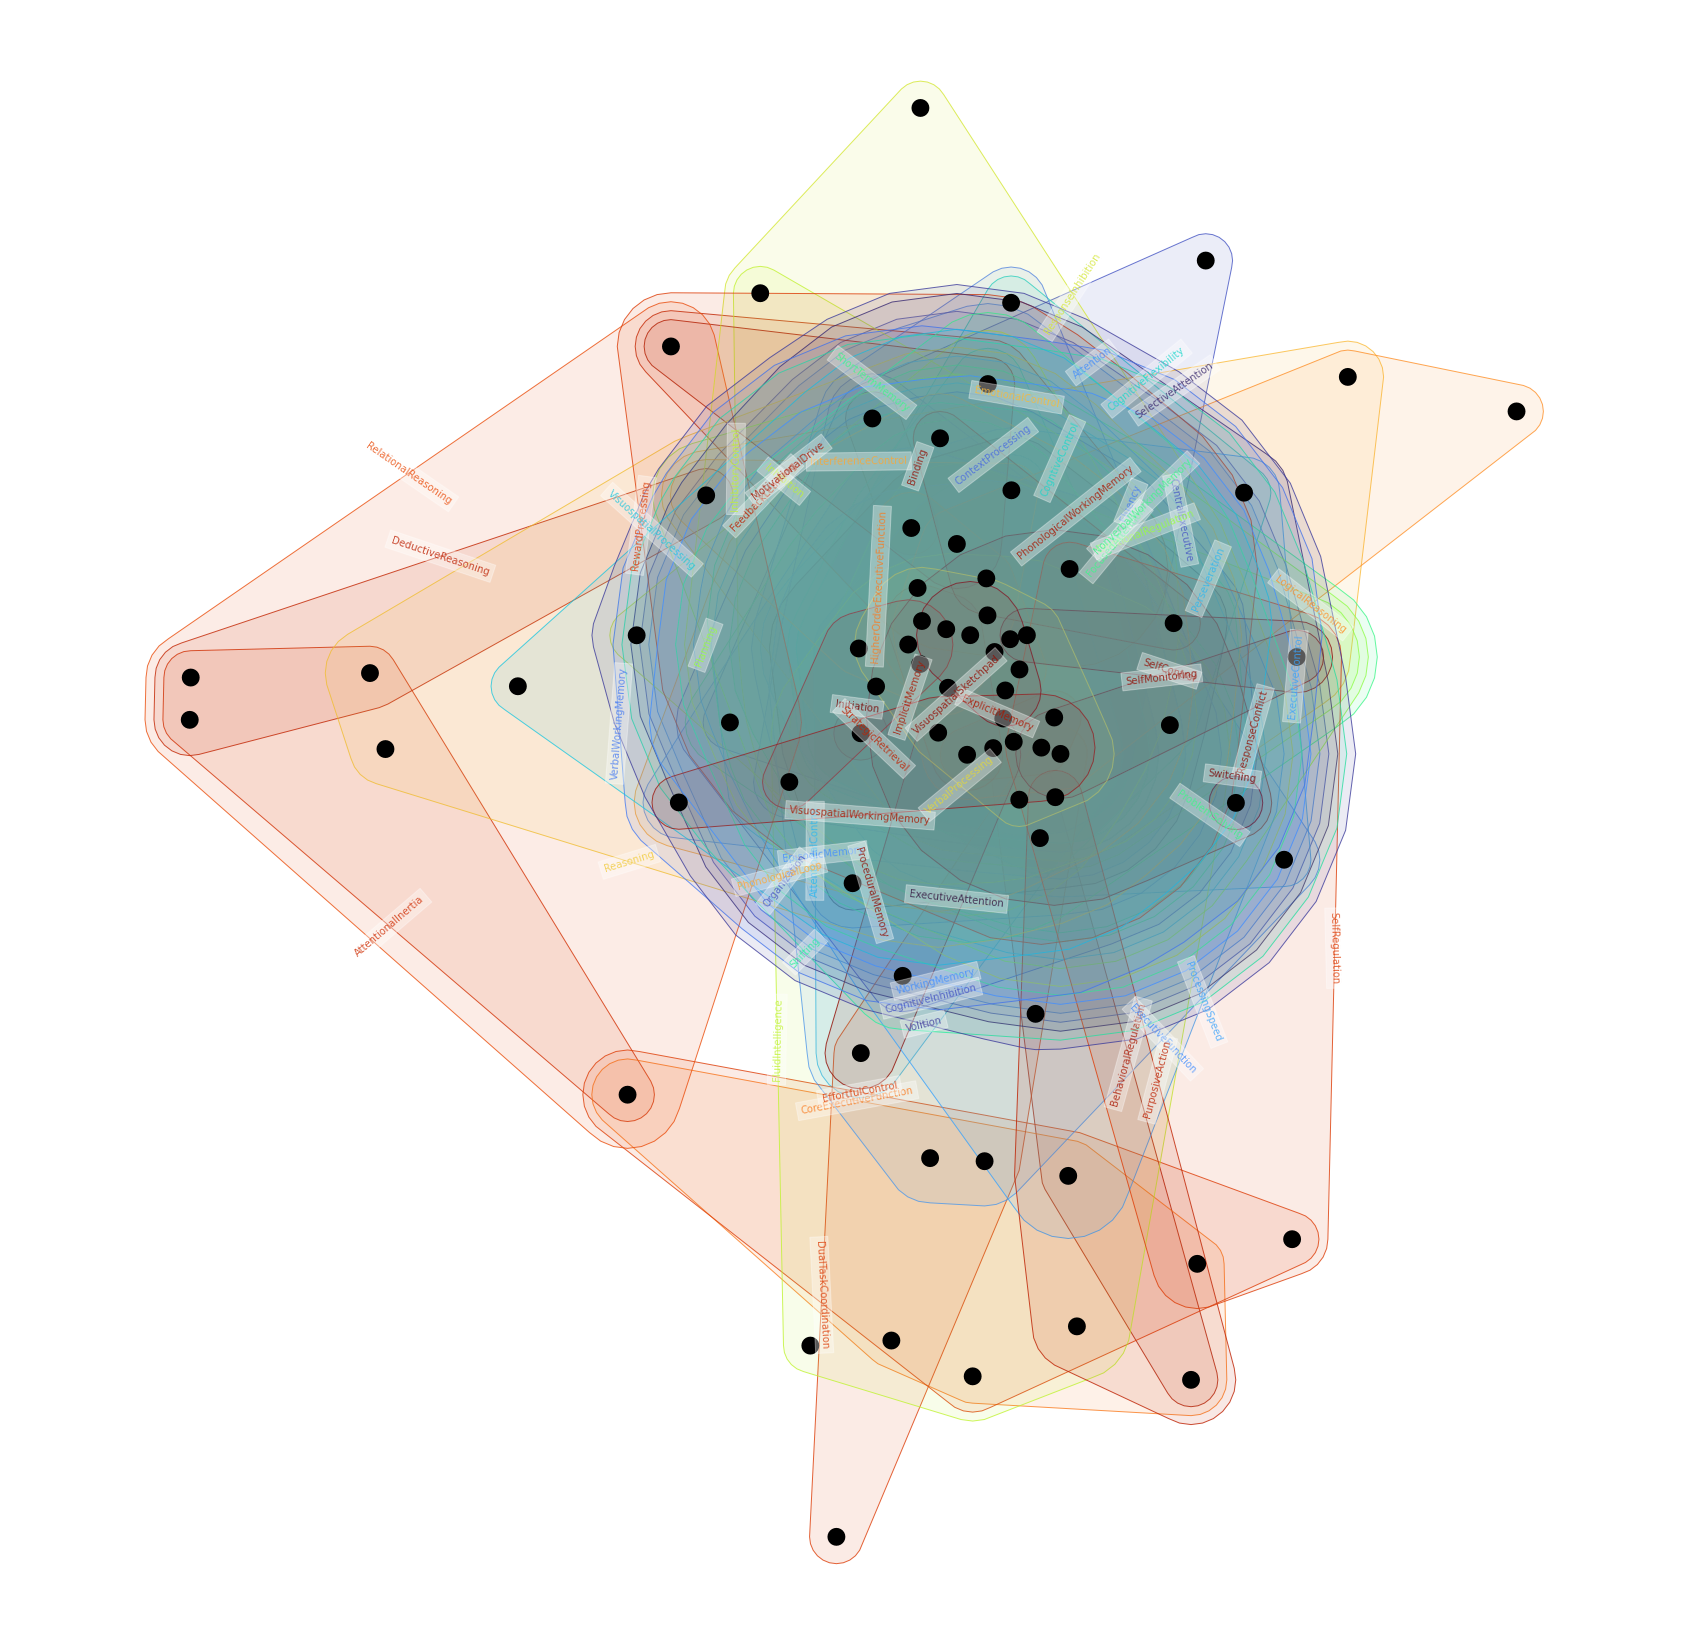

In [128]:
# create and plot the hypergraph

adj = sim.pivot(columns='construct', index='task').drop(columns='index', errors='ignore')
adj.columns = adj.columns.droplevel(0)
adj.index.name=None

HG = hnx.Hypergraph.from_dataframe(adj)


# # colors
cmap = plt.cm.turbo_r
edge_sizes = np.array([len(e) for e in HG.edges()])
norm = plt.Normalize(edge_sizes.min(), edge_sizes.max())
facecolors = cmap([norm(c) for c in edge_sizes]) * (1, 1, 1, 0.1)
edgecolors = cmap([norm(c) for c in edge_sizes]) * (1, 1, 1, .8)

fig, ax = plt.subplots(figsize=(30,30))
layout = nx.spring_layout
layout_args = {'scale': 1}#, 'seed': 42}
hnx.draw(HG,
         node_radius=.5,
         with_node_counts=True,
        #  with_node_labels=False,
        #  with_edge_labels=False,
        #  nodes_kwargs={'color': (0,0,0,.8)},
         edges_kwargs={'linewidths':1, 'edgecolors': edgecolors, 'facecolors': facecolors},
        #  layout=layout, layout_kwargs=layout_args,
         ax=ax)

plt.gca().invert_yaxis()

plt.show()

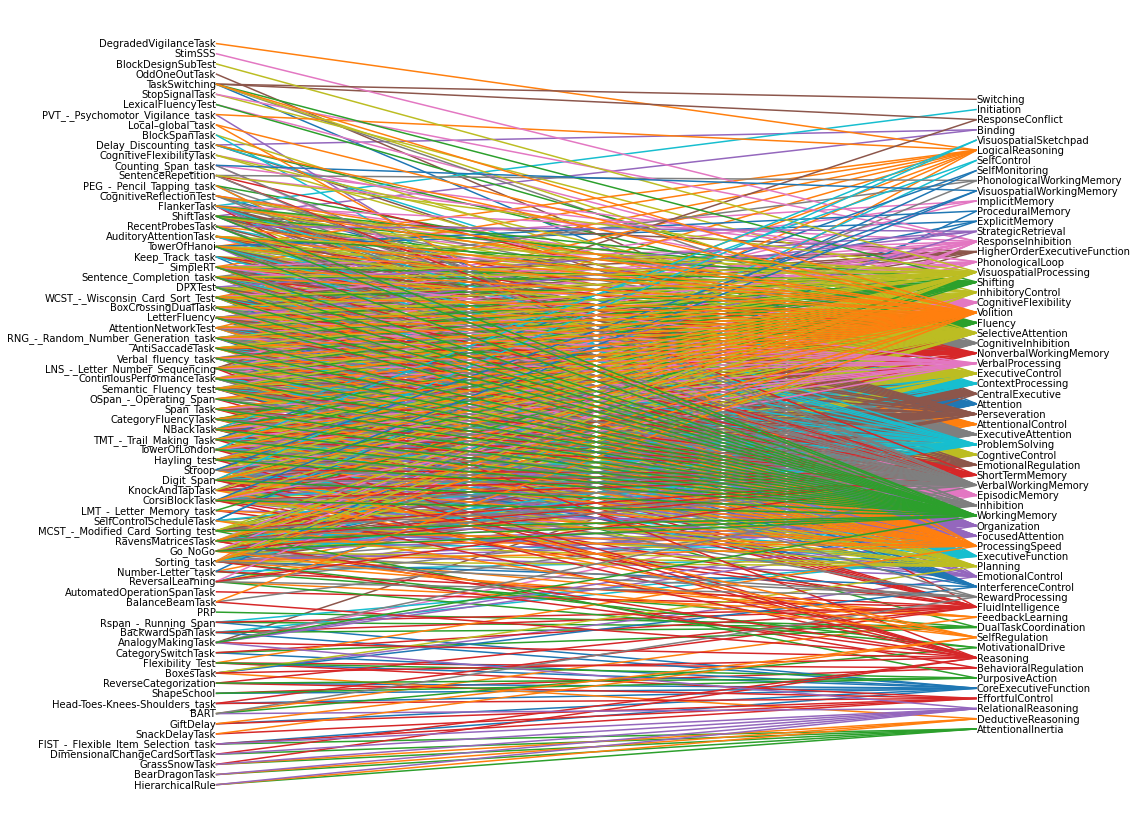

In [131]:
fig, ax = plt.subplots(figsize=(15,15))
hnx.draw_two_column(HG)

In [119]:
# editor

graph_editor = HypernetxWidget(HG, collapse=False)
graph_editor

HypernetxWidget(component='HypernetxWidget', props={'nodes': [{'uid': ('weight', 'FeedbackLearning')}, {'uid':…

In [117]:
graph_editor.pos

{}

In [6]:
pos = {'TwoStep': [167.6068737105813, 368.5197114001843],
 'BlockSpanTask': [600.4877390044605, 295.08638905072155],
 'ReverseCategorization': [209.09031713363328, 306.84204910360575],
 'SpinThePots': [146.51476029752155, 436.72926404521536],
 'BART': [243.6983136307005, 206.38521470886081],
 'ShapeSchool': [297.404050907824, 286.2415817283702],
 'SentenceRepetition': [436.2250475361636, 409.11799995387173],
 'RLG_-_Random_Letter_Generation_task': [96.67588759045512, 27.56850547428074],
 'GiftWrap': [328.0276339723625, 73.89257011711925],
 'HoltLaury': [112.89840221075235, 214.9313382324974],
 'ReversalLearning': [54.89840221075236, 54.60595503878335],
 'Semantic_Fluency_test': [501.22625223407204, 245.07561902455842],
 'DimensionalChangeCardSortTask': [365.7686528559197, 386.2565696429766],
 'FIST_-_Flexible_Item_Selection_task': [543.2340996968718, 438.0655988732748],
 'Verbal_fluency_task': [602.0689765594013, 49.18243510726117],
 'CategoryFluencyTask': [448.65614997796274, 137.64336915102893],
 'Delay_Discounting_task': [284.23313880518396, 227.38521470886081],
 'GrassSnowTask': [361.3533301470269, 126.01083619436668],
 'LetterFluency': [613.3984727892476, 75.18243510726117],
 'ColumbiaCardTask': [113.59057700095352, 347.25798766111296],
 'CognitiveFlexibilityTask': [156.51635954296228, 73.0012905413347],
 'DiscountingTask': [266.96572621794223, 179.90094577980454],
 'BlockDesignSubTest': [599.0225641789441, 268.08638905072155],
 'LexicalFluencyTest': [419.4752719446804, 48.91004428212847],
 'SnackDelayTask': [293.8419272258079, 118.8026163228214],
 'Head-Toes-Knees-Shoulders_task': [561.9178074545055, 354.5245712147973],
 'TMT_-_Trail_Making_Task': [492.01009711916385, 90.91004428212847],
 'Counting_Span_task': [456.759872710647, 315.11799995387173]}

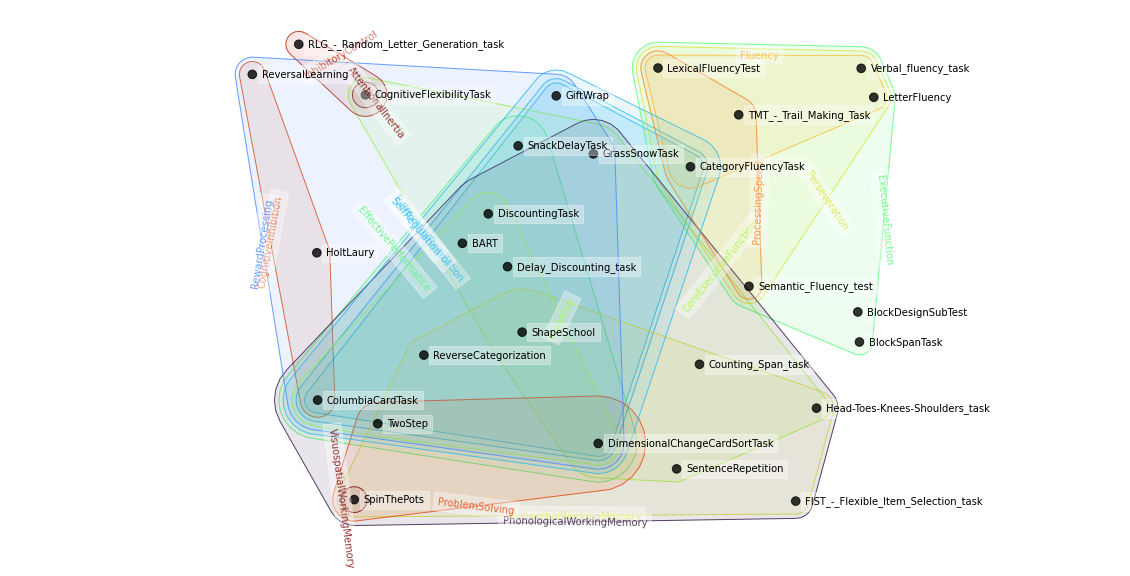

In [7]:
# plot the hypergraph

# colors
cmap = plt.cm.turbo_r
edge_sizes = np.array([len(e) for e in HG.edges()])
norm = plt.Normalize(edge_sizes.min(), edge_sizes.max())
facecolors = cmap([norm(c) for c in edge_sizes]) * (1, 1, 1, 0.1)
edgecolors = cmap([norm(c) for c in edge_sizes]) * (1, 1, 1, .8)

fig, ax = plt.subplots(figsize=(20,10))
layout = nx.spring_layout
layout_args = {'scale': 10}#, 'seed': 42}
hnx.draw(HG,
         pos = pos,
         node_radius=.5,
        #  with_node_labels=False,
        #  with_edge_labels=False,
         nodes_kwargs={'color': (0,0,0,.8)},
         edges_kwargs={'linewidths':1, 'edgecolors': edgecolors, 'facecolors': facecolors},
        #  layout=layout, layout_kwargs=layout_args,
         ax=ax)

plt.gca().invert_yaxis()

plt.show()

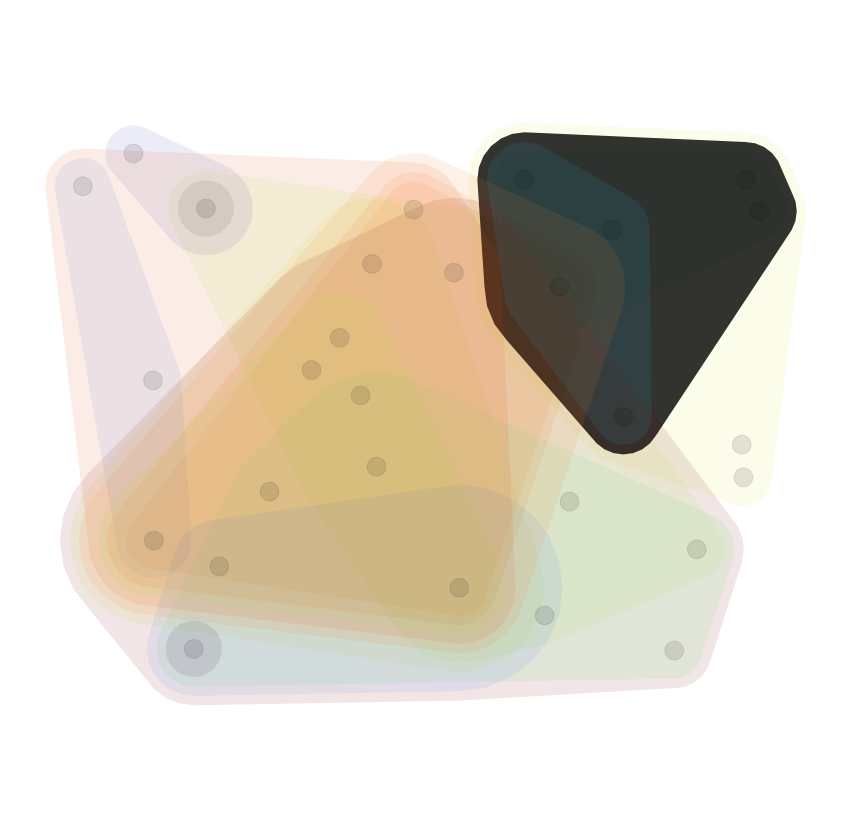

In [21]:
# plot labels

# colors
cmap = plt.cm.turbo
edge_sizes = np.array([len(e) for e in HG.edges()])
norm = plt.Normalize(edge_sizes.min(), edge_sizes.max())
facecolors = cmap([norm(c) for c in edge_sizes]) * (1, 1, 1, 0.1)
edgecolors = cmap([norm(c) for c in edge_sizes]) * (1, 1, 1, .8)

for i,e in enumerate(HG.edges()):
  if 'Perseveration' in e.uid:
    facecolors[i] = (0,0,0,.8)
  else:
    facecolors[i][3] = 0.1
    
fig, ax = plt.subplots(figsize=(15,15))
layout = nx.spring_layout
layout_args = {'scale': 10}#, 'seed': 42}
hnx.draw(HG,
         pos = pos,
         with_node_labels=False,
         with_edge_labels=False,
         nodes_kwargs={'color': (0,0,0,.1)},
         edges_kwargs={'linewidths':0, 'edgecolors': edgecolors, 'facecolors': facecolors},
        #  layout=layout, layout_kwargs=layout_args,
         ax=ax)

plt.gca().invert_yaxis()

plt.show()

In [132]:
%reload_ext watermark
# %watermark
%watermark -iv

sklearn   : 0.0
gensim    : 4.1.2
numpy     : 1.20.3
pandas    : 1.3.4
matplotlib: 3.4.3
hnxwidget : 0.1.1b1
seaborn   : 0.11.2
networkx  : 2.6.3
sys       : 3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:38:53) 
[Clang 11.1.0 ]
hypernetx : 1.2
igraph    : 0.9.8

